In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class NLS_Data():
    
    def __init__(self, file_path):
        self.file_path = file_path
        self.NLS_File = h5py.File(file_path, "r")
        # open and get file data from read only mode
        self.ch1_raw_adc_data = self.NLS_File['children']['0']['raw_data']
        self.ch2_raw_adc_data = self.NLS_File['children']['1']['raw_data']
        self.daq_adc_ref = self.NLS_File['children']['1']['meta']['daq_z_reference'][()]    
        self.daq_adc_increment = self.NLS_File['children']['1']['daq_z_increment'][()]
        self.tia_gain = self.NLS_File['children']['1']['convert_z_increment'][()]
        self.sample_name = self.NLS_File['sample_info']['id'][()]
        self.sample_area = self.NLS_File['sample_info']['DUTs']['0']['area'][()] * (1e-12)
        self.sample_thickness = self.NLS_File['sample_info']['DUTs']['0']['thickness'][()]
        self.sampling_period = self.NLS_File['children']['1']['daq_x_increment'][()]

    def detect_pulse_indices(self, data=None, threshold_factor=0.1, min_pulse_width=50):
        """
        检测数据中两个脉冲的起始和结束索引
        
        参数:
        - data: 输入数据数组（如果为None，则使用ch1_raw_adc_data）
        - threshold_factor: 阈值因子（默认0.1）
        - min_pulse_width: 最小脉冲宽度（默认50）
        
        返回:
        - tuple: (pulse1_start, pulse1_end, pulse2_start, pulse2_end) 
                 如果没找到2个脉冲则返回 (None, None, None, None)
        """
        if data is None:
            data = self.ch1_raw_adc_data
        # 计算基线
        baseline_start = np.mean(data[:100])
        baseline_end = np.mean(data[-100:])
        baseline = (baseline_start + baseline_end) / 2
        
        # 计算数据的极值
        data_max = np.max(data)
        data_min = np.min(data)
        
        # 计算正向和反向的范围
        positive_range = data_max - baseline
        negative_range = baseline - data_min
        
        # 判断脉冲类型并设置相应的检测逻辑
        if positive_range > negative_range:
            # 正向脉冲检测
            data_range = positive_range
            threshold = baseline + threshold_factor * data_range
            condition = data > threshold
        else:
            # 反向脉冲检测
            data_range = negative_range
            threshold = baseline - threshold_factor * data_range
            condition = data < threshold
        
        # 寻找脉冲边界
        pulse_starts = []
        pulse_ends = []
        
        in_pulse = False
        pulse_start_idx = 0
        
        for i in range(1, len(condition)):
            # 检测脉冲开始
            if not condition[i-1] and condition[i]:
                pulse_start_idx = i
                in_pulse = True
            
            # 检测脉冲结束
            elif condition[i-1] and not condition[i] and in_pulse:
                pulse_width = i - pulse_start_idx
                if pulse_width >= min_pulse_width:
                    pulse_starts.append(pulse_start_idx)
                    pulse_ends.append(i-1)
                in_pulse = False
        
        # 处理最后一个脉冲
        if in_pulse and len(data) - pulse_start_idx >= min_pulse_width:
            pulse_starts.append(pulse_start_idx)
            pulse_ends.append(len(data)-1)
        
        # 返回结果
        if len(pulse_starts) == 2:
            return pulse_starts[0], pulse_ends[0], pulse_starts[1], pulse_ends[1]
        else:
            return None, None, None, None
    
    def polarization_analysis(self):
        """
        极化分析函数 - 计算电场和净极化强度
        
        参数:
        - input_pulse: 输入脉冲数据（通常是ch1_raw_adc_data）
        - detect_pulse: 检测脉冲数据（通常是ch2_raw_adc_data）
        - daq_adc_ref: ADC参考值（0V对应的ADC值）
        
        返回:
        - tuple: (E_field, net_polarization) 
                 E_field: 电场强度数组
                 net_polarization: 净极化强度数组
                 如果检测失败则返回 None
        """
        input_pulse = self.ch1_raw_adc_data
        detect_pulse = self.ch2_raw_adc_data
        
        try:
            # 使用类内的detect_pulse_indices方法检测脉冲
            input_start1, input_end1, input_start2, input_end2 = self.detect_pulse_indices()
        except:
            print("No pulse detected")
            return None
        
        # 重新计算input2_end保证两个脉冲的duration相同
        input_end2 = input_end1 - input_start1 + input_start2
        
        # 提取两个脉冲的检测数据并转换为float64避免溢出
        detect_pulse1 = detect_pulse[input_start1:input_end1].astype(np.float64)
        detect_pulse2 = detect_pulse[input_start2:input_end2].astype(np.float64)
        # 由于detect_pulse的加减运算超过了uint16的表示范围，所以需要转换为float64
        
        # 计算净开关脉冲（两个脉冲的差值）
        net_switch_pulse = np.array(detect_pulse1) - np.array(detect_pulse2)
        
        # 转换为真实的开关电流
        pure_switch_current = (net_switch_pulse * self.daq_adc_increment) / self.tia_gain
        
        # 初始化净极化数组
        net_polarization = np.zeros(detect_pulse1.size)
        current_polarization = 0
        
        # 通过积分计算净极化强度
        for i in range(net_polarization.size):
            current_polarization += pure_switch_current[i] * self.sampling_period * self.sample_area
            net_polarization[i] = current_polarization
        
        # 计算输入电压和电场强度
        input_pulse1 = input_pulse[input_start1:input_end1].astype(np.float64)
        input_volt = (np.array(input_pulse1) - np.array(self.daq_adc_ref)) * self.daq_adc_increment
        E_field = input_volt * 1e-8 / self.sample_thickness
        # turn the unit to MV/cm
        
        return E_field, net_polarization    
        
    def plot_polarization(self):
        E_field, net_polarization = self.polarization_analysis()
        plt.figure(figsize=(12, 6))
        plt.plot(E_field, net_polarization)
        plt.title('Rectangular Pulse Induced Polarization Measured by ND')
        plt.xlabel('Electric Field (MV/cm)')
        plt.ylabel('Polarization (C/m^2)')
        plt.grid(True)
        plt.show()
        

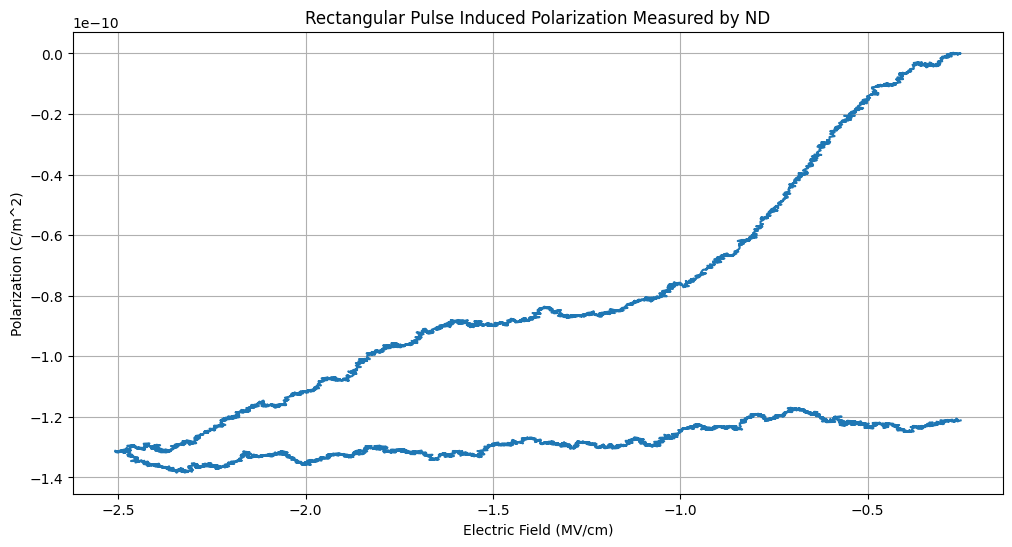

In [5]:
file_path = r'C:\Users\JeffreyQ\Desktop\UCLA_HW\Physics_Research\Regan_Group\Summer_REU\NLS_HZO\2025-08-05_big_cap\173600_holding_voltage_2.00_hold_time_0.00.hdf5'
trial1= NLS_Data(file_path)
trial1.plot_polarization()